# Getting started with tomsup

Tomsup, Theory of Mind Simulation using Python, is a Python Package for Agent Based simulations. It includes 1) a framework for running agent based simulations using 2 by 2 payoffmatrices and most notably 2) an implementation of game theory of mind in a agent based framework following the implementation of [Devaine, et al. (2017)](http://dx.plos.org/10.1371/journal.pcbi.1005833).

This tutorial will simply introduce the framework of tomsup, for an introduction to the theory of mind (ToM) agent, see *introduction_to_tom.ipynb*.

It is also possible for create your own agents for an introduction on this see *creating_an_agent.ipynb*. 

Lastly we have also created an brief introduction to each of the simpler agents for this see *introduction_to_basic_agents.ipynb*.


In [1]:
# assuming you are in the github folder change the path - not relevant if tomsup is installed via. pip
import os

print(os.getcwd())
os.chdir("..")  # go out of the tutorials folder

/Users/au561649/Desktop/Github/tomsup/python package/tutorials


In [1]:
import tomsup as ts

To get an overview of possible agent you can use the following function. Give you a brief description of their strategy as well as a reference for further reading.

In [2]:
ts.valid_agents()

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.7/site-packages/tomsup/agent_info.json'

---
## 1) Creating an agent
First we will set up a Random bias (RB) agent. This agent simply choses randomly with a given bias.
There is two ways to setup an agent, either using the agent class (e.g. RB) or using the ```create_agents()``` function. We will start by calling the agent class RB directy. For a whole list of valid agent use the ```ts.valid_agents()```.

In [3]:
jung = ts.RB(
    bias=0.7, save_history=True
)  # calling the agent subclass RB - for more on save_history see '3) inspecting Agent and AgentGroup'

# Let's examine the jung
print(f"jung is an class of type: {type(jung)}")
if isinstance(jung, ts.Agent):
    print(f"but jung is also an instance of the parent class ts.Agent")

# let us have Jung make a choice
choice = jung.compete()

print(f"jung chose {choice} and his probability for choosing 1 was {jung.get_bias()}.")

jung is an class of type: <class 'tomsup.agent.RB'>
but jung is also an instance of the parent class ts.Agent
jung chose 1 and his probability for choosing 1 was 0.7.


As previously mentioned you can also create agents using the `create_agent` function. Here we will create skinner as a Q-learning agent, which is a simple reinforcement learning agent, see Watkinns (1992) for more.

In [4]:
skinner = ts.create_agents(
    agents="QL", start_params={"save_history": True}
)  # create a reinforcement learning agent

Since skinner is a reinforcement learning agent his compete function requires him to know which game he is playing, so he can choose based on payoff. He also needs to know his opponents move during their last turn, so that he can update his belief about his opponent choices.

Let us have jung and skinner play the the matching pennies game. We can fetch the game from the function `PayoffMatrix`,

In [5]:
penny = ts.PayoffMatrix(
    name="penny_competitive"
)  # fetch the competitive matching pennies game.

# print the payoff matrix
print(penny)

# fetch the underlying numpy matrix
print(penny.get_matrix())

<Class PayoffMatrix, Name = penny_competitive> 
The payoff matrix of agent 0
       |  Choice agent 1
       |    |  0 |  1 |
       | ------------ |
Choice |  0 | -1 |  1 |
agent 0|  1 |  1 | -1 |
 
The payoff matrix of agent 1
       |  Choice agent 1
       |    |  0 |  1 |
       | ------------ |
Choice |  0 |  1 | -1 |
agent 0|  1 | -1 |  1 |
 
[[[-1  1]
  [ 1 -1]]

 [[ 1 -1]
  [-1  1]]]


Let us try to have skinner and jung compete in the matching pennies game:

In [6]:
jung_a = jung.compete()  # a for action
skinner_a = skinner.compete(
    p_matrix=penny, agent=1, op_choice=None
)  # Note that op_choice can be unspecified (or None) in the first round

jung_p = penny.payoff(choice_agent0=jung_a, choice_agent1=skinner_a, agent=0)
skinner_p = penny.payoff(choice_agent0=jung_a, choice_agent1=skinner_a, agent=1)

print(
    f"jung chose {jung_a} and skinner chose {skinner_a}, which results in a payoff for jung of {jung_p} and skinner of {skinner_p}."
)
# Note that you might get different results simply by chance

jung chose 0 and skinner chose 1, which results in a payoff for jung of 1 and skinner of -1.


---
## 2) Running a tournament
In the above case we saw how to have two agents compete for a single round. It is however rare that we only need 1 round and while the above functionality can be wrapped within a for we have made a `compete()` function for convenience. In this section we will also examine the class `AgentGroup`, which allows you to run tournaments with multiple agents.

Let us start with having the two agent compete for 30 rounds in the matching pennies game:

In [13]:
results = ts.compete(
    jung, skinner, p_matrix=penny, n_rounds=30, save_history=True, verbose=False
)
print(type(results))

jung_sum = results["payoff_agent0"].sum()
skinner_sum = results["payoff_agent1"].sum()

print(
    f"jung seemed to get a total of {jung_sum} points, while skinner got a total of {skinner_sum}."
)

results.head()  # inspect the first 5 rows of the df

<class 'tomsup.plot.ResultsDf'>
jung seemed to get a total of -14 points, while skinner got a total of 14.


,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1
0,0,1,1,-1,1,{'choice': 1},"{'choice': 1, 'expected_value0': 0.5, 'expecte..."
1,1,1,1,-1,1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
2,2,0,1,1,-1,{'choice': 0},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
3,3,1,1,-1,1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
4,4,1,1,-1,1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."


We see that the output of the compete function if a pandas dataframe. It is possible to change this to a list by specifying `return_val = "list"`, but having it as a dataframe allow for convenient operators attributes such as mean() and sum().

The above case a the simplest possible version of the `compete()` function. You can also specify number of simulations, whether the agent should be reset after each simulation (this is recommended) and whether it should print what simulation it is running (`silent`).




In [9]:
results = ts.compete(
    jung,
    skinner,
    penny,
    n_rounds=30,
    n_sim=3,
    save_history=True,
    return_val="df",
    verbose=True,
)
results.head()

	Running simulation 1 out of 3
	Running simulation 2 out of 3
	Running simulation 3 out of 3


,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1
0,0,0,0,1,1,-1,{'choice': 0},"{'choice': 1, 'expected_value0': 0.5, 'expecte..."
1,0,1,1,1,-1,1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
2,0,2,1,1,-1,1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
3,0,3,1,1,-1,1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
4,0,4,0,1,1,-1,{'choice': 0},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."


**Note** that by adding simulations the dataframe now also have a column called 'n_sim', for which simulations in which the results belongs.

### AgentGroup
Now as promised, let us take a look at tournaments with multiple agents. We will start of by creating a group of agents using a list of the desired agents as well as a list of their starting parameters. If you are in doubt how to specify these you can always the starting parameters from an existing agent using `jung.get_start_params()`.

In [15]:
agents = ["RB", "QL", "WSLS"]  # create a list of agents
start_params = [
    {"bias": 0.7},
    {"learning_rate": 0.5},
    {},
]  # create a list of their starting parameters (an empty dictionary {} simply assumes defaults)

group = ts.create_agents(agents, start_params)  # create a group of agents
print(group)
print("\n----\n")  # to space out the outputs

group.set_env(
    env="round_robin"
)  # round_robin e.g. each agent will play against all other agents

# make them compete
group.compete(p_matrix=penny, n_rounds=20, n_sim=4, verbose=True)
results = group.get_results()
results.head()  # examine the first 5 rows in results

<Class AgentGroup, envinment = None> 

RB	 | 	{'bias': 0.7}
QL	 | 	{'learning_rate': 0.5}
WSLS	 | 	{}

----

Currently the pair, ('RB', 'QL'), is competing for 4                         simulations, each containg 20 rounds.
	Running simulation 1 out of 4
	Running simulation 2 out of 4
	Running simulation 3 out of 4
	Running simulation 4 out of 4
Currently the pair, ('RB', 'WSLS'), is competing for 4                         simulations, each containg 20 rounds.
	Running simulation 1 out of 4
	Running simulation 2 out of 4
	Running simulation 3 out of 4
	Running simulation 4 out of 4
Currently the pair, ('QL', 'WSLS'), is competing for 4                         simulations, each containg 20 rounds.
	Running simulation 1 out of 4
	Running simulation 2 out of 4
	Running simulation 3 out of 4
	Running simulation 4 out of 4
Simulation complete


,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,agent0,agent1
0,0,0,0,0,-1,1,RB,QL
1,0,1,1,0,1,-1,RB,QL
2,0,2,0,0,-1,1,RB,QL
3,0,3,1,0,1,-1,RB,QL
4,0,4,0,0,-1,1,RB,QL


As you can see once the group is created and environment it is easy to have the agent compete with one another.

(for more possible environment, see `help(group.set_env)`)

---
## 3) Inspecting Agent and AgentGroup
So let's examine some of the attributes of the agents, which applies to all agents. In this section we will also look a bit into how to extract an agent from an agentGroup and how to examine the enviroment.

In [11]:
# What if I want to know the starting parameters?
print(
    "This is the starting parameters of jung: ", jung.get_start_params()
)  # Note that it also prints out default parameters
print("This is the starting parameters of skinner: ", skinner.get_start_params())

# What if I want to know the agent last choice?
print("This is jung's last choice: ", jung.get_choice())
print("This is skinner's last choice: ", skinner.get_choice())

# What if I want to know the agents strategy?
print("jung's strategy is: ", jung.get_strategy())
print("skinner's strategy is: ", skinner.get_strategy())

This is the starting parameters of jung:  {'bias': 0.7, 'save_history': True}
This is the starting parameters of skinner:  {'learning_rate': 0.5, 'b_temp': 0.01, 'expec_val': [0.5, 0.25], 'save_history': True}
This is jung's last choice:  1
This is skinner's last choice:  1
jung's strategy is:  RB
skinner's strategy is:  QL


We can also get the history, recall that we specified `get_history = True` for skinner (and jung). This means we can go back and see all his previous state for the Random bias (RB) this only include the choice. This is by default returned as a dataframe. Note that by default `save_history` is `False` to save memory.

In [12]:
# What is the history of skinner (e.g. what is his choices and internal states)

history = jung.get_history(format="df")
print(history.head())

print("\n --- \n")  # for spacing

history = skinner.get_history(format="df")
print(history.head(15))  # the first 15 rows

   choice
0       1
1       1
2       1
3       0
4       1

 --- 

    choice  expected_value0  expected_value1
0      1.0              0.5              1.0
1      1.0              0.5              1.0
2      1.0              0.5              1.0
3      1.0              0.5              1.0
4      1.0              0.5              1.0
5      1.0              0.5              1.0
6      1.0              0.5              1.0
7      1.0              0.5              1.0
8      1.0              0.5              1.0
9      1.0              0.5              1.0
10     1.0              0.5              1.0
11     1.0              0.5              1.0
12     1.0              0.5              1.0
13     1.0              0.5              1.0
14     1.0              0.5              1.0


In the above we can see the history of the two agents, both their internal states, which is none for the the random bias agent (RB) and includes two for the reinforcement learning agent (QL). The two for for the RL indicates the expected value of choosing 0 rather than 1. As expected we here see that the expected value of choosing 0 increases due to the jungs bias of 0.7.

**Note** that if the agent are competing using multiple simulations it will resets the agent after each simulations, consequently their history is also reset.

# 4) Plotting results
This section provides a few quick plotting options. These are meant to be quick and easy to use and should be considered sanity checks rather that. Let's start of by creating a plot of the score the Random bias agent over time.


<Figure size 432x288 with 0 Axes>

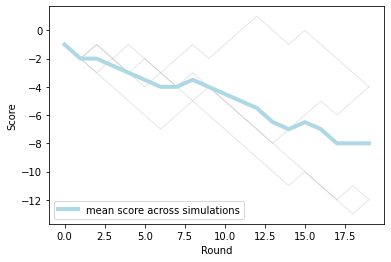

In [13]:
%matplotlib inline

ts.plot.score(results, agent0="RB", agent1="QL", agent=0)
# agent0 and agent1 indicate the agent pair which we want to plot
# agent = 0 indicate that the want to plot the performance of the agent0 (i.e. the RB agent)

Note that the grey lines indicate the score at each simulation, this should give you an indicatation of the uncertainty in the data. From this plot we see that the Random bias agent with a bias of 0.7 (as specified earlier) tend to loose against a reinformance learning agent (QL). This is a quite reasonable result.

We can also plot the agent actions over time using ```ts.plot.choice()```. This plot indicated the action of the agent over time. This function allows of the detect a change in preference. E.g. it would allow us to model periods of collaboration in a prisonners dilemma. In this specific case however it only really show is that the Random bias agent is biases towards 1. This is natural as it bias was 0.7, indicating that it will chose 1 70% of the time.

<Figure size 432x288 with 0 Axes>

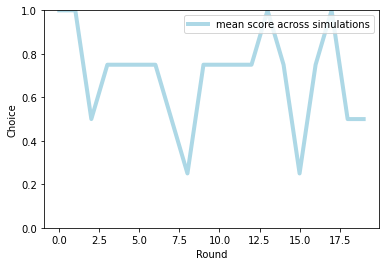

In [14]:
ts.plot.choice(results, agent0="RB", agent1="QL", agent=0)

In [15]:
# Create a list of agents
agents = ["RB", "QL", "WSLS", "1-TOM", "2-TOM"]
# And set their starting parameters. An empty dict denotes default values
start_params = [{"bias": 0.7}, {"learning_rate": 0.5}, {}, {}, {}]

group = ts.create_agents(agents, start_params)  # create a group of agents

# Specify the environment
# round_robin e.g. each agent will play against all other agents
group.set_env(env="round_robin")

# Finally, we make the group compete 20 simulations of 30 rounds
group.compete(p_matrix=penny, n_rounds=30, n_sim=20, save_history=True)

Currently the pair, ('RB', 'QL'), is competing for 20                         simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation 4 out of 20
	Running simulation 5 out of 20
	Running simulation 6 out of 20
	Running simulation 7 out of 20
	Running simulation 8 out of 20
	Running simulation 9 out of 20
	Running simulation 10 out of 20
	Running simulation 11 out of 20
	Running simulation 12 out of 20
	Running simulation 13 out of 20
	Running simulation 14 out of 20
	Running simulation 15 out of 20
	Running simulation 16 out of 20
	Running simulation 17 out of 20
	Running simulation 18 out of 20
	Running simulation 19 out of 20
	Running simulation 20 out of 20
Currently the pair, ('RB', 'WSLS'), is competing for 20                         simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation

In [16]:
res = group.get_results()
res.head(1)  # print the first row

,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1,agent0,agent1
0,0,0,1,0,1,-1,{'choice': 1},"{'choice': 0, 'expected_value0': 0.5, 'expecte...",RB,QL


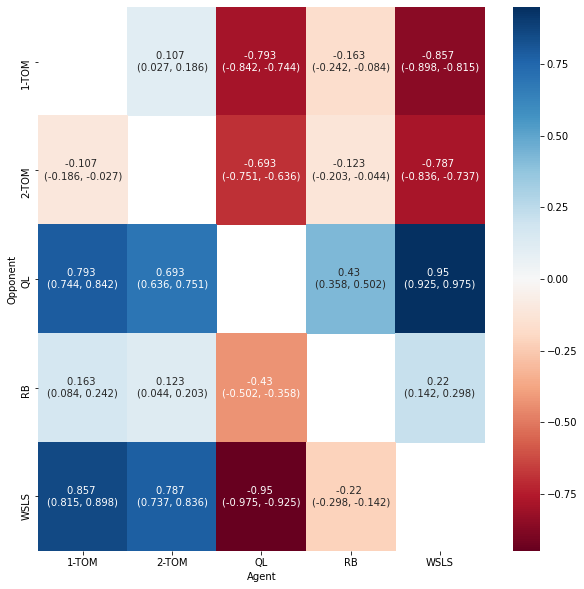

In [17]:
import matplotlib.pyplot as plt

# Set figure size
plt.rcParams["figure.figsize"] = [10, 10]

group.plot_heatmap(cmap="RdBu")

<Figure size 720x720 with 0 Axes>

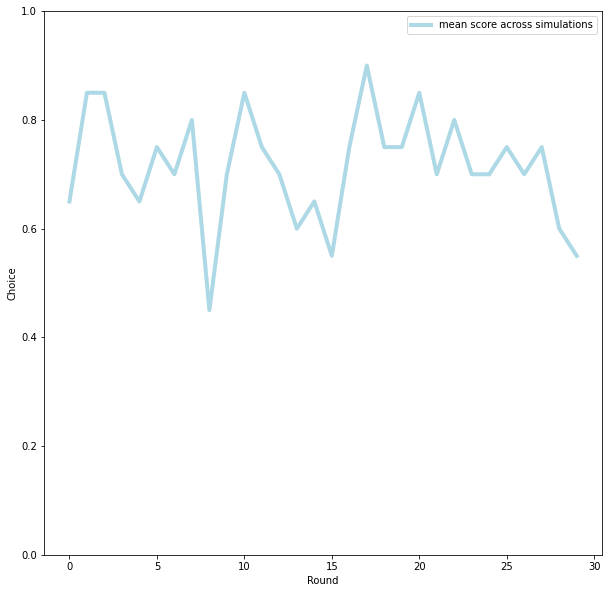

In [24]:
group.plot_choice(agent0="RB", agent1="QL", agent=0, plot_individual_sim=False)

<Figure size 720x720 with 0 Axes>

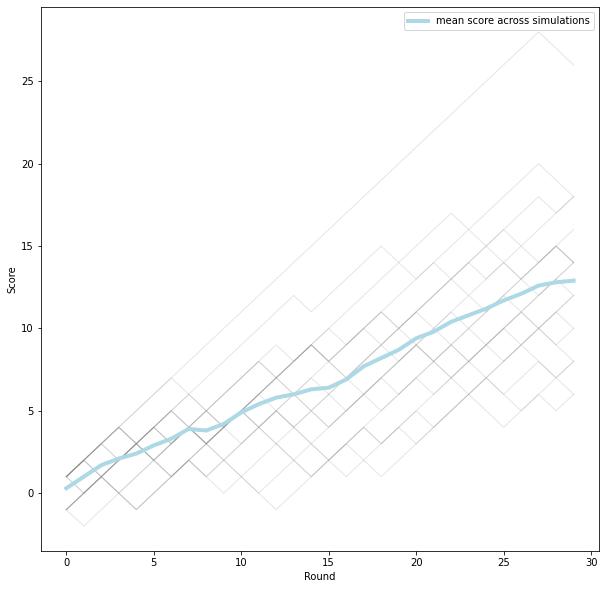

In [25]:
group.plot_score(agent0="RB", agent1="QL", agent=0)

<Figure size 720x720 with 0 Axes>

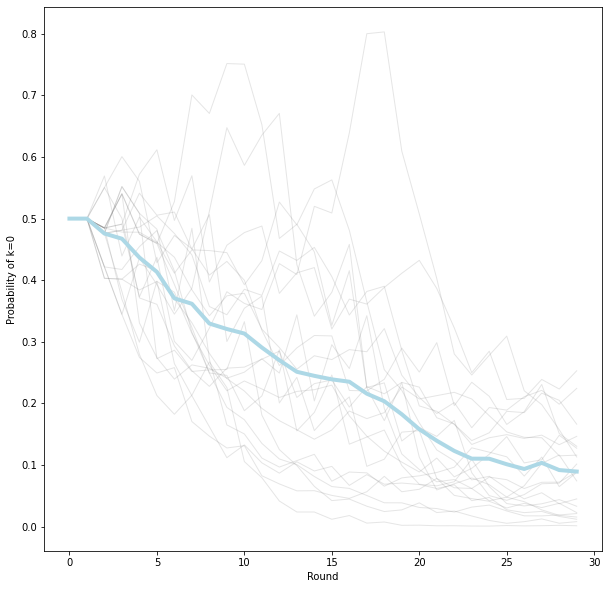

<Figure size 720x720 with 0 Axes>

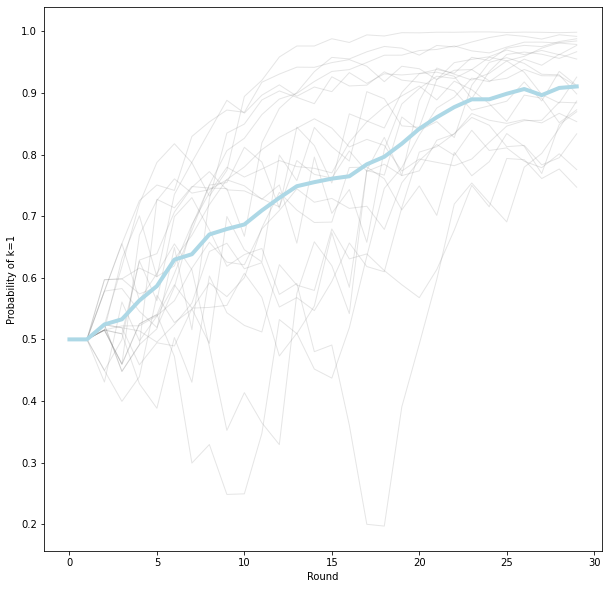

In [26]:
group.plot_p_k(agent0="1-TOM", agent1="2-TOM", agent=1, level=0)
group.plot_p_k(agent0="1-TOM", agent1="2-TOM", agent=1, level=1)

<Figure size 720x720 with 0 Axes>

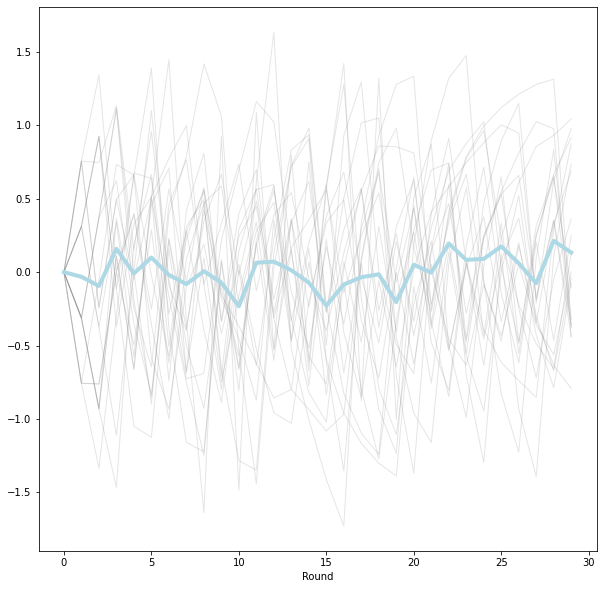

In [27]:
group.plot_history(
    "1-TOM",
    "2-TOM",
    agent=1,
    state="",
    fun=lambda x: x["internal_states"]["own_states"]["p_op_mean"][0],
)

In [29]:
df = group.get_results()
df.loc[(df["agent0"] == "1-TOM") & (df["agent1"] == "2-TOM")]["history_agent1"][1][
    "internal_states"
]["opponent_states"][1]["own_states"]

{'p_k': array([1.]),
 'p_op_mean': array([0.93468267]),
 'param_mean': array([[0. , 0. , 0.4]]),
 'param_var': array([[ 0.69314718,  0.        , -0.22314355]]),
 'gradient': array([[ 0.14210958, -0.53465593,  1.        ]])}

<Figure size 720x720 with 0 Axes>

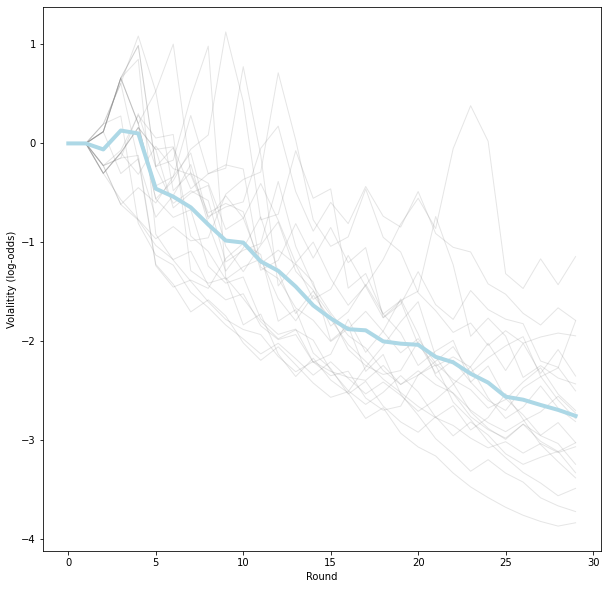

<Figure size 720x720 with 0 Axes>

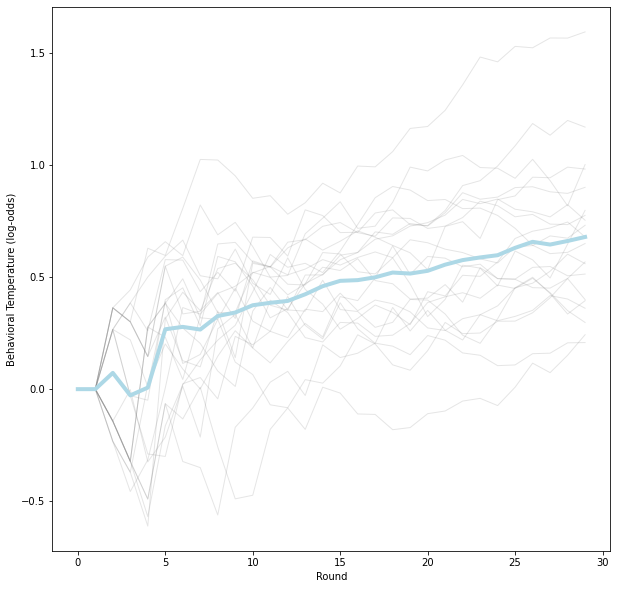

In [31]:
# volatility
group.plot_history(
    "1-TOM",
    "2-TOM",
    agent=1,
    state="",
    fun=lambda x: x["internal_states"]["opponent_states"][1]["own_states"][
        "param_mean"
    ][0, 0],
    ylab="Volalitity (log-odds)",
)
#

# behav temp
group.plot_history(
    "1-TOM",
    "2-TOM",
    agent=1,
    state="",
    fun=lambda x: x["internal_states"]["opponent_states"][1]["own_states"][
        "param_mean"
    ][0, 1],
    ylab="Behavioral Temperature (log-odds)",
)

## Simple Examples of the k-ToM agent
Here we will present some simple examples of the k-ToM agent. For a more in-depth description please check of the `introduction_to_tom.ipynb` in the tutorials folder ([link](https://github.com/KennethEnevoldsen/tomsup/blob/master/tutorials/introduction_to_tom.ipynb)).

We will start of by creating a 0-ToM with default priors and `save_history=True` to examine the workings of it. Notice that setting `save_history` is turned off by default to save on memory which is especially problematic for agent with high sophistication level.

In [98]:
# ktom simple example
tom_1 = ts.TOM(level=1, dilution=None, save_history=True)

# Extact the parameters
print(tom_1.get_parameters())

{'volatility': -2, 'b_temp': -1, 'bias': 0}


Note that k-ToM agents in the tomsup package use agnostic priors about their opponent's level probabilities it is possible to change this and even manipulate then on a pr. round basis for an example of this see `introduction_to_tom.ipynb` ([link](https://github.com/KennethEnevoldsen/tomsup/blob/master/tutorials/introduction_to_tom.ipynb)).

To increase its chance of choosing one we could simply add a increase its bias. Similarly, if we want it to behave more deterministically we can decrease the behavioural tempareture. We can have it play against an opponent as previously using the `.compete()` method.



In [99]:
tom_2 = ts.TOM(
    level=2,
    volatility=-2,
    b_temp=-2,  # more deterministic
    bias=0,
    dilution=None,
    save_history=True,
)

In [100]:
choice = tom_2.compete(p_matrix=penny, agent=0, op_choice=None)
print(choice)

1


Naturally, one could have the 0-ToM and the 2-ToM compete for using the group method or premade `ts.compete()` function as already presented, but to be more explicit we will create a simple for-loop:

In [101]:
tom_2.reset()  # reset before start


prev_choice_1tom = None
prev_choice_2tom = None
for trial in range(1, 4):
    # note that op_choice is choice on previous turn
    # and that agent is the agent you repond to the in payoff matrix
    choice_1 = tom_1.compete(p_matrix=penny, agent=0, op_choice=prev_choice_1tom)
    choice_2 = tom_2.compete(p_matrix=penny, agent=1, op_choice=prev_choice_2tom)

    # update previous choice
    prev_choice_1tom = choice_1
    prev_choice_2tom = choice_2

    print(
        f"Round {trial}",
        f"  1-ToM choose {choice_1}",
        f"  2-ToM choose {choice_2}",
        sep="\n",
    )

Round 1
  1-ToM choose 1
  2-ToM choose 1
Round 2
  1-ToM choose 1
  2-ToM choose 0
Round 3
  1-ToM choose 1
  2-ToM choose 1


A for loop like this is also how one could implement k-ToM in an experimental setting by replacing of of the agent with a participants input. For a full example using psychopy see our sample [script](https://github.com/KennethEnevoldsen/tomsup/tree/master/tutorials/psychopy_experiment). 

tomsup also have convenient functions for checking the internal states of the ToM agent:

In [108]:
tom_2.print_internal(keys=["p_k", "p_op"], level=[0, 1])

opponent_states
|   0-ToM
|   |   opponent_states
|   |   own_states
|   1-ToM
|   |   opponent_states
|   |   |   0-ToM
|   |   |   |   opponent_states
|   |   |   |   own_states
|   |   own_states
|   |   |   p_k:         [1.0]
own_states
|   p_k:         [0.4216107483109084, 0.5783892516890916]
|   p_op:        0.5282429642617794


We see that for instance the estimate of the opponent sophistication level `p_k` slightly favor a 1-ToM as opposed to a 0-ToM and that the average probability of the opponent choosing one `p_op` slightly favors 1, which we see the opponent in fact choose. Notice these estimates are quite uncertain due to the few rounds played. For an explanation of how to interpret the internal states of the ToM agent please use the help function e.g. `help(tom_2.print_internal)`.

In [113]:
help(tom_2.print_internal)  # more explanation to be added

Help on method print_internal in module tomsup.agent:

print_internal(keys_to_print=None, print_level=None, silent=False, print_as_str=False) method of tomsup.agent.TOM instance
    keys_to_print (list) is the keys which you desire to print. If key is
    print_level (list) list of integers containing levels to print
    None all keys will be printed.

